In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
u_cols = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv("./data/ml-100k/u.user", sep="|", header=None, names=u_cols, encoding="latin-1")
print("Number of users:", users.shape[0])

#rates
r_cols = ["user_id", "item_id", "rating", "unix_timestamp"]
ratings_base = pd.read_csv("./data/ml-100k/ua.base", sep="\t", header=None, names=r_cols, encoding="latin-1")
ratings_test = pd.read_csv("./data/ml-100k/ua.test", sep="\t", header=None, names=r_cols, encoding="latin-1")
print("Number of ratings in base set:", ratings_base.shape[0])
print("Number of ratings in test set:", ratings_test.shape[0])

#items
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')
print("Number of items:", items.shape[0])

Number of users: 943
Number of ratings in base set: 90570
Number of ratings in test set: 9430
Number of items: 1682


In [3]:
user_mean_ratings = ratings_base.groupby('user_id')['rating'].mean()

- **Hàm tính độ tương đồng**
  - Tính điểm trung bình của các users đã rate cho mỗi item.
  - $U$: là tập users đã đánh giá cả $a$ và $b$.

  $$
  \text{sim}(\vec{a}, \vec{b}) = \frac{\sum_{u \in U} (r_{u,a} - \bar{r}_u)(r_{u,b} - \bar{r}_u)}{\sqrt{\sum_{u \in U} (r_{u,a} - \bar{r}_u)^2} \sqrt{\sum_{u \in U} (r_{u,b} - \bar{r}_u)^2}}
  $$

In [7]:
def pearson_correlation(item1, item2):
    """
    Calculate the Pearson correlation coefficient between two items.
    """
    # Get the ratings for both items
    ratings1 = ratings_base[ratings_base['item_id'] == item1]
    ratings2 = ratings_base[ratings_base['item_id'] == item2]

    # Merge the two dataframes on user_id
    merged_ratings = pd.merge(ratings1, ratings2, on='user_id', suffixes=('_item1', '_item2'))

    # if there are less than 3 common users, return 0
    if len(merged_ratings) < 3:
        return 0
    
    # Calculate the mean ratings for both items
    mean_item1 = merged_ratings['rating_item1'].mean()
    mean_item2 = merged_ratings['rating_item2'].mean()

    # Calculate the numerator and denominator for the Pearson correlation
    numerator = np.sum((merged_ratings['rating_item1'] - mean_item1) * (merged_ratings['rating_item2'] - mean_item2))
    denominator = np.sqrt(np.sum((merged_ratings['rating_item1'] - mean_item1) ** 2) * np.sum((merged_ratings['rating_item2'] - mean_item2) ** 2))

    if denominator == 0:
        return 0

    correlation = numerator / denominator
    
    if len(merged_ratings) < 50:
        correlation = correlation * (len(merged_ratings)/50)
    
    return correlation

In [8]:
pearson_correlation(1, 2)

np.float64(0.23440488208226357)

In [9]:
class LazySimilarityMatrix:
    def __init__(self):
        self.similarity_cache = {}
        
    def get_similarity(self, item1, item2):
        """Get similarity between two items with caching"""
        if item1 == item2:
            return 1.0
        
        # Use a consistent order for the key to avoid duplicates
        cache_key = tuple(sorted([item1, item2]))
        
        if cache_key not in self.similarity_cache:
            sim = pearson_correlation(item1, item2)
            self.similarity_cache[cache_key] = sim
            
        return self.similarity_cache[cache_key]
    
    def get_top_k_similar_items(self, item_id, k=20, exclude_negative=True):
        """Find k items most similar to the given item"""
        item_ids = ratings_base["user_id"].unique()
        similarities = []
        
        for other_item_id in item_ids:
            if other_item_id != item_id:
                sim = self.get_similarity(item_id, other_item_id)
                # Option to exclude users with negative correlation
                if not exclude_negative or sim > 0:
                    similarities.append((other_item_id, sim))
        
        # Sort by similarity (descending) and take top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:k]

In [10]:
similarity_matrix = LazySimilarityMatrix()

- **Hàm gợi ý:**

  $$
  \text{pred}(u, p) = \frac{\sum_{i \in \text{ratedItem}(u)} \text{sim}(i, p) * r_{u,i}}{\sum_{i \in \text{ratedItem}(u)} \text{sim}(i, p)}
  $$

In [ ]:
def predict_rating(user_id, item_id, k=20, rating_range=(1, 5)):
    # Check if the user has already rated this item
    is_rated = ratings_base[(ratings_base['user_id'] == user_id) & (ratings_base['item_id'] == item_id)]
    if not is_rated.empty:
        return is_rated['rating'].iloc[0]
    
    items_rated_by_user = ratings_base[ratings_base['user_id'] == user_id]
    
    similar_items = similarity_matrix.get_top_k_similar_items(item_id, k)
    
    numerator = 0
    denominator = 0
    
    for similar_item_id, sim in similar_items:
        # Check if the user has rated the similar item
        user_rating = items_rated_by_user[items_rated_by_user['item_id'] == similar_item_id]
        
        if not user_rating.empty:
            rating = user_rating['rating'].iloc[0]
            numerator += sim * rating
            denominator += abs(sim)
    
    if denominator == 0:
        # Nếu không có đủ thông tin, trả về điểm trung bình của user
        if user_id in user_mean_ratings:
            return user_mean_ratings[user_id]
        else:
            # Nếu user chưa đánh giá item nào, trả về giá trị trung bình tổng thể
            return ratings_base['rating'].mean()
    
    predicted_rating = numerator / denominator
    
    # Đảm bảo rating nằm trong khoảng hợp lệ
    predicted_rating = max(rating_range[0], min(predicted_rating, rating_range[1]))
    
    return predicted_rating

In [25]:
from tqdm import tqdm
def evaluate_model(k=20, metric='rmse'):
    """
    Evaluate the recommender model on the test set
    
    Parameters:
    k: Number of similar users to consider
    metric: Evaluation metric ('rmse' or 'mae')
    
    Returns:
    float: Error metric value (lower is better)
    """
    errors = []
    total = len(ratings_test)
    print(f"Evaluating model with k={k} on {total} test samples...")
    
    # Optional: show progress for long evaluations
    progress_step = max(1, total // 10)
    
    with tqdm(total=total, desc="Evaluating", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:
        for _, row in ratings_test.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            predicted_rating = predict_rating(user_id, item_id, k)

            if metric == 'rmse':
                errors.append((predicted_rating - actual_rating) ** 2)
            else:  # mae
                errors.append(abs(predicted_rating - actual_rating))
            
            pbar.update(1)
            
    if metric == 'rmse':
        return np.sqrt(np.mean(errors))
    else:  # mae
        return np.mean(errors)

In [26]:
error = evaluate_model(k=20, metric='rmse')
print(f"RMSE with k=20: {error:.4f}")

Evaluating model with k=20 on 9430 test samples...


Evaluating: 100%|███████████████████████████████████████████████| 9430/9430 [19:35<00:00,  8.02it/s]

RMSE with k=20: 1.1000


In [31]:
def find_optimal_k(k_values=None):
    """Find the optimal k value for the KNN algorithm"""
    if k_values is None:
        k_values = [5, 10, 20, 30, 40, 50]
    
    results = []
    
    for k in k_values:
        # Use a small sample for efficiency
        sample_size = len(ratings_test)
        sample = ratings_test.sample(sample_size)
        
        errors = []
        for _, row in sample.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            predicted_rating = predict_rating(user_id, item_id, k)
            errors.append((predicted_rating - actual_rating) ** 2)
        
        rmse = np.sqrt(np.mean(errors))
        results.append((k, rmse))
        print(f"k={k}, RMSE={rmse:.4f}")
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    k_list = [result[0] for result in results]
    rmse_list = [result[1] for result in results]
    
    plt.plot(k_list, rmse_list, marker='o')
    plt.xlabel('k (Number of neighbors)')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. k')
    plt.grid(True)
    plt.savefig('Item-KNN_optimization.png')
    plt.show()
    
    # Find k with lowest error
    optimal_k = min(results, key=lambda x: x[1])
    return optimal_k

k=5, RMSE=1.1431
k=10, RMSE=1.1219
k=15, RMSE=1.1102
k=20, RMSE=1.1000
k=25, RMSE=1.0881
k=30, RMSE=1.0816
k=35, RMSE=1.0738
k=40, RMSE=1.0709
k=45, RMSE=1.0687
k=50, RMSE=1.0610
k=55, RMSE=1.0549
k=60, RMSE=1.0506
k=65, RMSE=1.0472
k=70, RMSE=1.0447
k=75, RMSE=1.0431
k=80, RMSE=1.0413
k=85, RMSE=1.0394
k=90, RMSE=1.0376
k=95, RMSE=1.0367
k=100, RMSE=1.0333
k=105, RMSE=1.0316
k=110, RMSE=1.0301
k=115, RMSE=1.0292
k=120, RMSE=1.0279
k=125, RMSE=1.0272
k=130, RMSE=1.0266
k=135, RMSE=1.0257
k=140, RMSE=1.0248
k=145, RMSE=1.0242
k=150, RMSE=1.0218
k=155, RMSE=1.0206
k=160, RMSE=1.0214
k=165, RMSE=1.0210
k=170, RMSE=1.0205
k=175, RMSE=1.0197
k=180, RMSE=1.0182
k=185, RMSE=1.0185
k=190, RMSE=1.0180
k=105, RMSE=1.0316
k=200, RMSE=1.0174


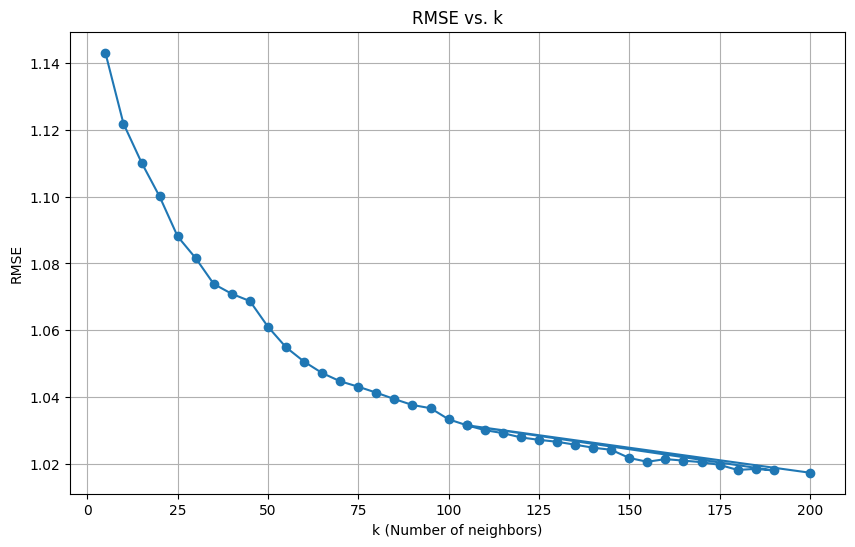

Optimal k: 200 with RMSE: 1.0174


In [33]:
optimal_k, optimal_rmse = find_optimal_k(k_values=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150,
                                                   155, 160, 165, 170, 175, 180, 185, 190, 105, 200])
print(f"Optimal k: {optimal_k} with RMSE: {optimal_rmse:.4f}")